In [1]:
import pandas as pd

# Carregar o dataset
df = pd.read_csv('dataset/publications_aminer.csv', delimiter=';')

print(df.head())


                  author_id      author_name  \
0  5a33917406df07e704c7afd5  Barry Wilkinson   
1  5a33917406df07e704c7afd5  Barry Wilkinson   
2  5a33917406df07e704c7afd5  Barry Wilkinson   
3  5a33917406df07e704c7afd5  Barry Wilkinson   
4  5a33917406df07e704c7afd5  Barry Wilkinson   

                                           coauthors  \
0        Mark A. Holliday,Barry Wilkinson,James Ruff   
1  Rahman Tashakkori,Barry L. Kurtz,Barry Wilkins...   
2  Oscar Ardaiz-Villanueva,Miguel L. Bote-Lorenzo...   
3    Barry Wilkinson,Mark A. Holliday,Clayton Ferner   
4         Barry Wilkinson,Tanusree Pai,Meghana Miraj   

                                   publication_title  abstract  \
0  Using an end-to-end demonstration in an underg...       NaN   
1      A consortium to promote distributed computing       NaN   
2  Collaborative and learning applications of gri...       NaN   
3  Experiences in teaching a geographically distr...       NaN   
4     A Distributed Shared Memory Programmin

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('dataset/publications_aminer.csv', delimiter=';')

# Tratamento de colunas e linhas
df['abstract'].fillna('No Data', inplace=True)
df['publication_title'].fillna('No Data', inplace=True)
df['venue'].fillna('No Data', inplace=True)
df['coauthors'].fillna('No Data', inplace=True)

# Criar uma nova coluna 'num_coauthors' que conta o número de coautores
df['num_coauthors'] = df['coauthors'].apply(lambda x: len(x.split(',')) if x != 'No Data' else 0)

# Codificar a coluna 'author_id' como classe
label_encoder = LabelEncoder()
df['author_class'] = label_encoder.fit_transform(df['author_id'])


print(df)

# Separar os arquivos de treino e teste
X = df[['publication_title', 'coauthors', 'venue', 'abstract', 'num_coauthors']]
y = df['author_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Comparação: TF-IDF vs Usar o número de coautores

# Modelo com TF-IDF
preprocessor_tfidf = make_column_transformer(
    (TfidfVectorizer(), 'publication_title'),
    (TfidfVectorizer(), 'coauthors'),
    (TfidfVectorizer(), 'venue'),
    (TfidfVectorizer(), 'abstract'),
    remainder='passthrough'
)


#print(preprocessor_tfidf)

model_tfidf = make_pipeline(preprocessor_tfidf, RandomForestClassifier(n_estimators=100, random_state=42))

# Treinamento do modelo com TF-IDF
model_tfidf.fit(X_train.drop(columns='num_coauthors'), y_train)




# previsões com TF-IDF
y_pred_tfidf = model_tfidf.predict(X_test.drop(columns='num_coauthors'))




# Modelo Sem TF-IDF (Usando o número de coautores)
preprocessor_num_coauthors = make_column_transformer(
    (TfidfVectorizer(), 'publication_title'),
    (TfidfVectorizer(), 'venue'),
    (TfidfVectorizer(), 'abstract'),
    remainder='passthrough'
)

model_num_coauthors = make_pipeline(preprocessor_num_coauthors, RandomForestClassifier(n_estimators=100, random_state=42))

# Treinando o modelo com o número de coautores (sem TF-IDF)
model_num_coauthors.fit(X_train[['publication_title', 'venue', 'abstract', 'num_coauthors']], y_train)

# Fazer previsoes com o número de coautores
y_pred_num_coauthors = model_num_coauthors.predict(X_test[['publication_title', 'venue', 'abstract', 'num_coauthors']])

# Calcular F1-Score para o modelo com TF-IDF 
precision_tfidf = precision_score(y_test, y_pred_tfidf, average='micro')
recall_tfidf = recall_score(y_test, y_pred_tfidf, average='micro')
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='micro')
#print(f"TF-IDF - Precision: {precision_tfidf}, Recall: {recall_tfidf}, F1-Score: {f1_tfidf}")
print(f"TF-IDF - F1-Score: {f1_tfidf}")

# Calcular F1-Score para o modelo com número de coautores 
precision_num_coauthors = precision_score(y_test, y_pred_num_coauthors, average='micro')
recall_num_coauthors = recall_score(y_test, y_pred_num_coauthors, average='micro')
f1_num_coauthors = f1_score(y_test, y_pred_num_coauthors, average='micro')
#print(f"Número de Coautores - Precision: {precision_num_coauthors}, Recall: {recall_num_coauthors}, F1-Score: {f1_num_coauthors}")
print(f"Número de Coautores - F1-Score: {f1_num_coauthors}")

# Função para prever o author_id para um novo dado de teste
def prever_author(publication_title, coauthors, venue, abstract, num_coauthors, usar_tfidf=True):
    """Função para prever o author_id para um dado de teste."""
    novo_dado = pd.DataFrame({
        'publication_title': [publication_title],
        'coauthors': [coauthors],
        'venue': [venue],
        'abstract': [abstract],
        'num_coauthors': [num_coauthors]
    })
    
    if usar_tfidf:
        pred = model_tfidf.predict(novo_dado.drop(columns='num_coauthors'))
    else:
        pred = model_num_coauthors.predict(novo_dado[['publication_title', 'venue', 'abstract', 'num_coauthors']])
    
    return label_encoder.inverse_transform(pred)

# Exemplo de uso:
print(prever_author("Distributed Computing", "John Doe, Jane Smith", "CCGRID", "An abstract about computing", 2, usar_tfidf=True))
print(prever_author("Grid Technology", "Michael Johnson, Alice Brown", "SIGCSE", "An abstract about grid technology", 2, usar_tfidf=False))


/tmp/ipykernel_687/2062415191.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['abstract'].fillna('No Data', inplace=True)
/tmp/ipykernel_687/2062415191.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No Data' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['abstract'].fillna('No Data', inplace=True)
/tmp/ipykernel_687/2062415191.py:14: FutureWarning: A value is trying to be set on a copy

                     author_id      author_name  \
0     5a33917406df07e704c7afd5  Barry Wilkinson   
1     5a33917406df07e704c7afd5  Barry Wilkinson   
2     5a33917406df07e704c7afd5  Barry Wilkinson   
3     5a33917406df07e704c7afd5  Barry Wilkinson   
4     5a33917406df07e704c7afd5  Barry Wilkinson   
...                        ...              ...   
1829  cf5b3a3f71242c7c02fc9180   Jose M. García   
1830  cf5b3a3f71242c7c02fc9180   Jose M. García   
1831  cf5b3a3f71242c7c02fc9180   Jose M. García   
1832  cf5b3a3f71242c7c02fc9180   Jose M. García   
1833  cf5b3a3f71242c7c02fc9180   Jose M. García   

                                              coauthors  \
0           Mark A. Holliday,Barry Wilkinson,James Ruff   
1     Rahman Tashakkori,Barry L. Kurtz,Barry Wilkins...   
2     Oscar Ardaiz-Villanueva,Miguel L. Bote-Lorenzo...   
3       Barry Wilkinson,Mark A. Holliday,Clayton Ferner   
4            Barry Wilkinson,Tanusree Pai,Meghana Miraj   
...                              

Comparação de F1 Score dos Modelos (TF-IDF vs Número de Coautores):

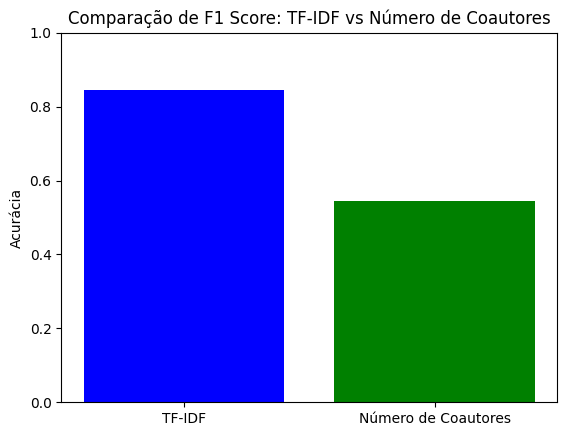

In [12]:
import matplotlib.pyplot as plt

# Dados do F1
f1s_score = [f1_tfidf, f1_num_coauthors]
labels = ['TF-IDF', 'Número de Coautores']

# Plotando o gráfico de barras
plt.bar(labels, f1s_score, color=['blue', 'green'])
plt.title('Comparação de F1 Score: TF-IDF vs Número de Coautores')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
plt.show()


Confusion Matrix (Matriz de Confusão):

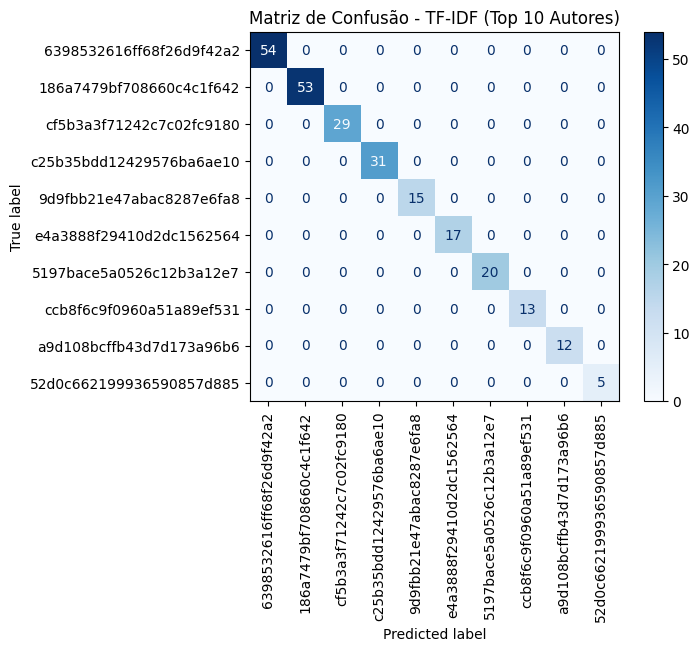

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Definir o número de autores a serem exibidos
N = 10

# Obter as N classes (autores) mais frequentes
top_authors = df['author_class'].value_counts().index[:N]

# Filtrar os dados de treino e teste para incluir apenas esses autores
X_test_top = X_test[y_test.isin(top_authors)]
y_test_top = y_test[y_test.isin(top_authors)]
y_pred_tfidf_top = model_tfidf.predict(X_test_top.drop(columns='num_coauthors'))

# Gerar a matriz de confusão para os N autores mais frequentes
cm = confusion_matrix(y_test_top, y_pred_tfidf_top, labels=top_authors)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.inverse_transform(top_authors))
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - TF-IDF (Top {N} Autores)')
plt.xticks(rotation=90)
plt.show()


In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Carregar o dataset
df = pd.read_csv('dataset/publications_aminer.csv', delimiter=';')

# Codificar a coluna 'author_id' como classes
label_encoder = LabelEncoder()
df['author_class'] = label_encoder.fit_transform(df['author_id'])

# Contar a quantidade de registros por 'author_class' (label) e organizar em DataFrame
registros_por_label = df['author_class'].value_counts().reset_index()
registros_por_label.columns = ['author_class', 'quantidade_registros']

# Exibir os resultados em uma tabela
print(registros_por_label)


     author_class  quantidade_registros
0             103                   186
1              17                   186
2             228                    77
3             204                    76
4             163                    66
..            ...                   ...
275           141                     1
276           220                     1
277           219                     1
278           224                     1
279           111                     1

[280 rows x 2 columns]
